### References

**Book:**
- Deep Learning with Python, Second Edition
  - Book by François Chollet
  - François Chollet is a French software engineer and artificial intelligence researcher currently working at Google. Chollet is the creator of the Keras deep-learning library, released in 2015, and a main contributor to the TensorFlow machine learning framework.


### Processing words as a sequence

These past few examples clearly show that word order matters: manual engineering of order-based features, such as bigrams, yields a nice accuracy boost. 

Now remember: the history of deep learning is that of a move away from manual feature engineering, toward letting models learn their own features from exposure to data alone.

What if, instead of manually crafting order-based features, we exposed the model to raw word sequences and let it figure out such features on its own.

To implement a sequence model, you’d start by representing your input samples as sequences of integer indices (one integer standing for one word). 

Then, you’d map each integer to a vector to obtain vector sequences. Finally, you’d feed these sequences of vectors into a stack of layers that could cross-correlate features from adjacent vectors.

For some time around 2016–2017, bidirectional RNNs (in particular, bidirectional LSTMs) were considered to be the state of the art for sequence modeling. 

This is what we’ll use in our first sequence model examples. However, nowadays sequence modeling is almost universally done with Transformers.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

In [3]:
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [4]:
# Prepare a dataset  that only yields raw text inputs (no labels)
text_only_train_ds = train_ds.map(lambda x, y: x)

In [5]:
max_length = 600
max_tokens = 20000

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    )

text_vectorization.adapt(text_only_train_ds)

```
text_vectorization = TextVectorization(
    output_mode="int",
    standardize=custom_standardization_fn,
    split=custom_split_fn,
    )
```

Previously we used `output_sequence_length` parameter. So, all the words of each review will be considered.

But in the above implementation `output_sequence_length=max_length` where `max_length = 600` so we are only considering first 600 words of each review.

In [10]:
int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

The simplest way to convert our integer sequences to vector sequences is to one-hot encode the integers (each dimension would represent one possible term in the vocabulary).

In [11]:
# One input is a sequence of integers
inputs = keras.Input(shape=(None,), dtype="int64")
# Encode the integers into binary 20,000 dimensional vectors
embedded = tf.one_hot(inputs, depth=max_tokens)

x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

In [ ]:
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [12]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot_1 (TFOpLambda)   (None, None, 20000)       0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                5128448   
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5128513 (19.56 MB)
Trainable params: 5128513 (19.56 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [13]:
# Training a first basic sequence model

callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
                                    ]

model.fit(int_train_ds, 
          validation_data=int_val_ds, 
          epochs=10,
          callbacks=callbacks)

Epoch 1/10

140/625 [=====>........................] - ETA: 1:28:24 - loss: 0.6902 - accuracy: 0.5232

KeyboardInterrupt: 

A first observation: this model trains very slowly, especially compared to the lightweight model of the previous section. 

This is because our inputs are quite large: each input sample is encoded as a matrix of size (600, 20000) (600 words per sample, 
20,000 possible words). 

That’s 12,000,000 floats for a single movie review. Our bidirectional LSTM has a lot of work to do. Second

In [ ]:
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Second, the model only gets to 87% test accuracy—it doesn’t perform nearly as well as our (very fast) binary unigram model.

Clearly, using one-hot encoding to turn words into vectors, which was the simplest thing we could do, wasn’t a great idea. There’s a better way: word embeddings.

**Understanding Word Embeddings**

Crucially, when you encode something via one-hot encoding, you’re making a feature engineering decision. You’re injecting into your model a fundamental assumption about the structure of your feature space. 

That assumption is that the different tokens you’re encoding are all independent from each other: indeed, one-hot vectors are all orthogonal to one another. 

And in the case of words, that assumption is clearly wrong. Words form a structured space: they share information with each other. The words “movie” and “film” are interchangeable in most sentences, so the vector that represents “movie” should not be orthogonal to the vector that represents “film”—they should be the same vector, or close enough.

To get a bit more abstract, the geometric relationship between two word vectors should reflect the semantic relationship between these words.

Besides being dense representations, word embeddings are also structured representations, and their structure is learned from data. Similar words get embedded in close locations, and further, specific directions in the embedding space are meaningful.

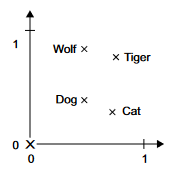

With the vector representations we chose here, some semantic relationships between these words can be encoded as geometric transformations. 

For instance, the same vector allows us to go from cat to tiger and from dog to wolf: this vector could be interpreted as the “from pet to wild animal” vector. 

Similarly, another vector lets us go from dog to cat and from wolf to tiger, which could be interpreted as a “from canine to feline” vector.

In real-world word-embedding spaces, common examples of meaningful geometric transformations are “gender” vectors and “plural” vectors.

For instance, by adding a “female” vector to the vector “king,” we obtain the vector “queen.” 

By adding a “plural” vector, we obtain “kings.” 

There are two ways to obtain word embeddings:

- Learn word embeddings jointly with the main task you care about (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network.
- Load into your model word embeddings that were precomputed using a different machine learning task than the one you’re trying to solve. These are called pretrained word embeddings.

### LEARNING WORD EMBEDDINGS WITH THE EMBEDDING LAYER

In [14]:
# Instantiating an Embedding layer
# [input_dim = The number of possible tokens] and [output_dim = the dimensionality of the embeddings (here, 256)]
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

The Embedding layer is best understood as a dictionary that maps integer indices (which stand for specific words) to dense vectors. It takes integers as input, looks up these integers in an internal dictionary, and returns the associated vectors. It’s effectively a dictionary lookup.

The Embedding layer takes as input a rank-2 tensor of integers, of shape (batch_size, sequence_length), where each entry is a sequence of integers. The layer then returns a 3D floating-point tensor of shape (batch_size, sequence_length, embedding_dimensionality)

In [15]:
# Model that uses an Embedding layer trained from scratch

# batch size (32) x sequence length (600)
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)

x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

In [16]:
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [17]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5194049 (19.81 MB)
Trainable params: 5194049 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_lstm.keras",
                                    save_best_only=True)
                                    ]

model.fit(int_train_ds, 
          validation_data=int_val_ds, 
          epochs=10,
          callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 437s 687ms/step - loss: 0.5223 - accuracy: 0.7419 - val_loss: 0.4130 - val_accuracy: 0.8360
Epoch 2/10
625/625 [==============================] - 371s 593ms/step - loss: 0.3524 - accuracy: 0.8658 - val_loss: 0.3397 - val_accuracy: 0.8676
Epoch 3/10
 25/625 [>.............................] - ETA: 5:33 - loss: 0.3484 - accuracy: 0.8838

KeyboardInterrupt: 

In [ ]:
model = keras.models.load_model("embeddings_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

It trains much faster than the one-hot model (since the LSTM only has to process 256-dimensional vectors instead of 
20,000-dimensional), and its test accuracy is comparable (87%). 

However, we’re still some way off from the results of our basic bigram model. 

Part of the reason why is simply that the model is looking at slightly less data: the bigram model processed full reviews, while our sequence model truncates sequences after 600 words.

### UNDERSTANDING PADDING AND MASKING

One thing that’s slightly hurting model performance here is that our input sequences are full of zeros. 

This comes from our use of the output_sequence_length=max_length option in TextVectorization (with max_length equal to 600): sentences longer than 600 tokens are truncated to a length of 600 tokens, and sentences shorter than 600 tokens are padded with zeros at the end so that they can be concatenated together with other sequences to form contiguous batches.

We’re using a bidirectional RNN: two RNN layers running in parallel, with one processing the tokens in their natural order, and the other processing the same tokens in reverse. 

The RNN that looks at the tokens in their natural order will spend its last iterations seeing only vectors that encode padding—possibly for several hundreds of iterations if the original sentence was short. 

The information stored in the internal state of the RNN will gradually fade out as it gets exposed to these meaningless inputs.

**We need some way to tell the RNN that it should skip these iterations. There’s an API for that: masking.**

The Embedding layer is capable of generating a “mask” that corresponds to its input data. This mask is a tensor of ones and zeros (or True/False booleans), of shape (batch_size, sequence_length), where the entry mask[i, t] indicates where timestep t of sample i should be skipped or not (the timestep will be skipped if mask[i, t] is 0 or False, and processed otherwise).

By default, this option isn’t active—you can turn it on by passing mask_zero=True to your Embedding layer. You can retrieve the mask with the compute_mask() method.

```
embedding_layer = Embedding(input_dim=10, output_dim=256, mask_zero=True)

some_input = [
... [4, 3, 2, 1, 0, 0, 0],
... [5, 4, 3, 2, 1, 0, 0],
... [2, 1, 0, 0, 0, 0, 0]]

mask = embedding_layer.compute_mask(some_input)

<tf.Tensor: shape=(3, 7), dtype=bool, numpy=
array([[ True, True, True, True, False, False, False],
[ True, True, True, True, True, False, False],
[ True, True, False, False, False, False, False]])>
```

In practice, you will almost never have to manage masks by hand. Instead, Keras will automatically pass on the mask to every layer that is able to process it (as a piece of metadata attached to the sequence it represents). This mask will be used by RNN layers to skip masked steps. 

If your model returns an entire sequence, the mask will also be used by the loss function to skip masked steps in the output sequence.

In [19]:
# Using an Embedding layer with masking enabled

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)

x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

In [20]:
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [21]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5194049 (19.81 MB)
Trainable params: 5194049 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_lstm_with_masking.keras",
                                    save_best_only=True)
                                    ]

model.fit(int_train_ds,
          validation_data=int_val_ds,
          epochs=10,
          callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 501s 786ms/step - loss: 0.4303 - accuracy: 0.7982 - val_loss: 0.3229 - val_accuracy: 0.8636
Epoch 2/10
165/625 [======>.......................] - ETA: 5:32 - loss: 0.3118 - accuracy: 0.8744

KeyboardInterrupt: 

In [ ]:
model = keras.models.load_model("embeddings_bidir_lstm_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

This time we get to 88% test accuracy—a small but noticeable improvement.

### USING PRETRAINED WORD EMBEDDINGS

Sometimes you have so little training data available that you can’t use your data alone to learn an appropriate task-specific embedding of your vocabulary. 

In such cases, instead of learning word embeddings jointly with the problem you want to solve, you can load embedding vectors from a precomputed embedding space that you know is highly structured and exhibits useful properties—one that captures generic aspects of language structure.

Such word embeddings are generally computed using word-occurrence statistics (observations about what words co-occur in sentences or documents), using a variety of techniques, some involving neural networks, others not. 

The idea of a dense, low dimensional embedding space for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s,1 but it only started to take off in research and industry applications after the release of one of the most famous and successful word-embedding schemes: the Word2Vec algorithm, developed by Tomas Mikolov at Google in 2013. Word2Vec dimensions capture specific semantic properties, such as gender.

There are various precomputed databases of word embeddings that you can download and use in a Keras Embedding layer. Word2vec is one of them. 

Another popular one is called Global Vectors for Word Representation (GloVe), which was developed by Stanford researchers in 2014. This embedding technique is based on factorizing a matrix of word co-occurrence statistics. 

Its developers have made available precomputed embeddings for millions of English tokens, obtained from Wikipedia data and Common Crawl data.

let’s download the GloVe word embeddings precomputed on the 2014 English Wikipedia dataset. It’s an 822 MB zip file containing 100-dimensional embedding vectors for 400,000 words (or non-word tokens).

```
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip
```

Let’s parse the unzipped file (a .txt file) to build an index that maps words (as strings) to their vector representation.

In [23]:
import numpy as np

In [27]:
# Parsing the GloVe word-embeddings file

path_to_glove_file = "glove/glove.6B.100d.txt"

embeddings_index = {}

with open(path_to_glove_file, encoding="utf-8") as f:
    for line in f:
        # The maxsplit=1 argument ensures the line is split only once, separating the first word (the word itself) from the rest of the line (the coefficients)
        word, coefs = line.split(maxsplit=1)
        # This line converts the string coefs (which contains the numerical coefficients separated by spaces) into a NumPy array of floating-point numbers ("f") using " " (space) as the separator between each coefficient
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
        
print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [32]:
# First 10 keys
list(embeddings_index.keys())[:10]

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]

In [33]:
# Embedding vector of the word "the"
embeddings_index["the"]

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

Next, let’s build an embedding matrix that you can load into an Embedding layer. 

It must be a matrix of shape (max_words, embedding_dim), where each entry i contains the embedding_dim-dimensional vector for the word of index i in the reference word index (built during tokenization).

In [34]:
# Preparing the GloVe word-embeddings matrix

embedding_dim = 100

# Retrieve the vocabulary indexed by our previous TextVectorization layer
vocabulary = text_vectorization.get_vocabulary()

# Creating dictionary (word, index)
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Creating embedding matrix with zeros (all possible words/tokens, embedding dimension)
# Designed to store embedding vectors of all the tokens index wise (as per word index)
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Iterating through words and corresponding indices from word_index dictionary
for word, i in word_index.items():
    # Checking index < max_tokens because there will be much more words in the word_index dictionary than we are considering in this case 
    if i < max_tokens:
        # Getting the embedding vector of that word from embeddings_index dictionary
        embedding_vector = embeddings_index.get(word)
    # Checking whether we have some embedding (embeddings wont be captured if [i > max_tokens])
    if embedding_vector is not None:
        # If we have some embedding then we are storing that embedding vector at a particular index of embedding_matrix matrix 
        embedding_matrix[i] = embedding_vector

Finally, we use a Constant initializer to load the pretrained embeddings in an Embedding layer. 

So as not to disrupt the pretrained representations during training, we freeze the layer via trainable=False

In [35]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
    )

We’re now ready to train a new model—identical to our previous model, but leveraging the 100-dimensional pretrained GloVe embeddings instead of 128-dimensional learned embeddings.

In [36]:
# Model that uses a pretrained Embedding layer

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)

x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

In [37]:
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [38]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_4 (Bidirecti  (None, 64)                34048     
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2034113 (7.76 MB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 2000000 (7.63 MB)
_________________

In [39]:
callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
    save_best_only=True)
    ]

model.fit(int_train_ds, 
          validation_data=int_val_ds, 
          epochs=10,
          callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 448s 700ms/step - loss: 0.5853 - accuracy: 0.6844 - val_loss: 0.4548 - val_accuracy: 0.7936
Epoch 2/10
326/625 [==============>...............] - ETA: 2:21 - loss: 0.4675 - accuracy: 0.7827

KeyboardInterrupt: 

In [ ]:
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

You’ll find that on this particular task, pretrained embeddings aren’t very helpful, because the dataset contains enough samples that it is possible to learn a specialized enough embedding space from scratch. 

However, leveraging pretrained embeddings can be very helpful when you’re working with a smaller dataset.